[reference](https://www.kaggle.com/raufmomin/vision-transformer-vit-fine-tuning/notebook)

In [5]:
!pip install tensorflow-addons

In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from pprint import pprint

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.4.1


In [97]:
IMAGE_SIZE = 32
BATCH_SIZE = 16
EPOCHS = 7

TRAIN_PATH = "../data/input/train"
TEST_PATH = "../data/input/test"

DF_TRAIN = pd.read_csv('../data/input/train_master.tsv', sep='\t', dtype='str')
label_master = pd.read_csv('../data/input/label_master.tsv', sep='\t')
TEST_IMAGES = glob.glob(TEST_PATH + '/*.png')
DF_TEST = pd.DataFrame(TEST_IMAGES, columns=['image_path'])

In [28]:
classes = label_master['label_name'].to_dict()
pprint(classes)

{0: 'aquatic_mammals',
 1: 'fish',
 2: 'flowers',
 3: 'food_containers',
 4: 'fruit_and_vegetables',
 5: 'household_electrical_devices',
 6: 'household_furniture',
 7: 'insects',
 8: 'large_carnivores',
 9: 'large_man-made_outdoor_things',
 10: 'large_natural_outdoor_scenes',
 11: 'large_omnivores_and_herbivores',
 12: 'medium_mammals',
 13: 'non-insect_invertebrates',
 14: 'people',
 15: 'reptiles',
 16: 'small_mammals',
 17: 'trees',
 18: 'vehicles_1',
 19: 'vehicles_2'}


In [43]:
DF_TRAIN.head()

,file_name,label_id
0,train_00000.png,11
1,train_00001.png,15
2,train_00002.png,4
3,train_00003.png,14
4,train_00004.png,1


In [39]:
DF_TEST.head()

,image_path
0,../data/input/test\test_00000.png
1,../data/input/test\test_00001.png
2,../data/input/test\test_00002.png
3,../data/input/test\test_00003.png
4,../data/input/test\test_00004.png


## Data Augumentations

In [44]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Files
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > 0.75:
        image = tf.image.transpose(image)
        
    # Rotate
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

## Data Generator

In [45]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    samplewise_center = True,
    samplewise_std_normalization = True,
    validation_split = 0.2,
    preprocessing_function = data_augment
)

train_gen = datagen.flow_from_dataframe(
    dataframe = DF_TRAIN,
    directory = TRAIN_PATH,
    x_col = 'file_name',
    y_col = 'label_id',
    subset = 'training',
    batch_size = BATCH_SIZE,
    seed = 1,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = 'categorical',
    target_size = (IMAGE_SIZE, IMAGE_SIZE)
)

valid_gen = datagen.flow_from_dataframe(
    dataframe = DF_TRAIN,
    directory = TRAIN_PATH,
    x_col = 'file_name',
    y_col = 'label_id',
    subset = 'validation',
    batch_size = BATCH_SIZE,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = 'categorical',
    target_size = (IMAGE_SIZE, IMAGE_SIZE)
)

test_gen = datagen.flow_from_dataframe(
    dataframe = DF_TEST,
    x_col = 'image_path',
    y_col = None,
    batch_size = BATCH_SIZE,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = None,
    target_size = (IMAGE_SIZE, IMAGE_SIZE)
)

Found 40000 validated image filenames belonging to 20 classes.
Found 10000 validated image filenames belonging to 20 classes.
Found 10000 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

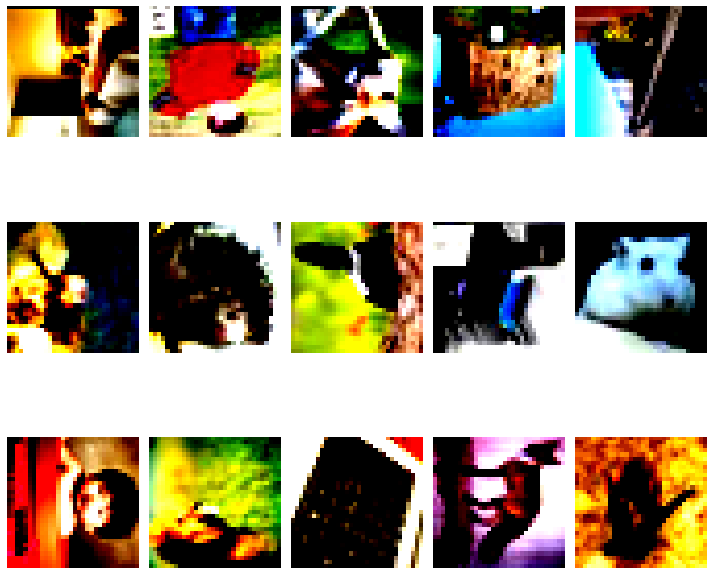

In [63]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')
    
plt.tight_layout()
plt.show()

## Building the Model

In [86]:
!pip install --quiet vit-keras
from vit_keras import vit

## 1. ViTB32 Model

In [89]:
vit_model = vit.vit_b32(
    image_size=IMAGE_SIZE,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=len(classes)
)

353255424/353253686 [==============================] - 32s 0us/step


Visualizing Attention Maps of Sample Test Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


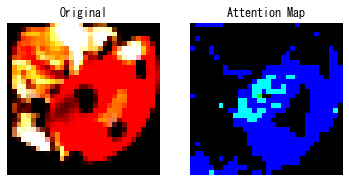

In [94]:
from vit_keras import visualize

x = test_gen.next()
image = x[0]

attention_map = visualize.attention_map(model=vit_model, image=image)

# plot 
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## 2. Fine-tuning the Model

In [99]:
model = tf.keras.Sequential(
    [
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(len(classes), 'softmax')
    ],
    name = 'vision_transformer'
)
model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b32 (Functional)         (None, 768)               87418368  
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 768)               3072      
_________________________________________________________________
dense_2 (Dense)              (None, 11)                8459      
_________________________________________________________________
batch_normalization_3 (Batch (None, 11)                44        
_________________________________________________________________
dense_3 (Dense)              (None, 20)                240       
Total params: 87,430,183
Trainable params: 87,428,625
Non-trainable params: 1,558
________________________________

## Trainig the Model

In [100]:
learning_rate = 1e-4
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy']
)

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=2,
    verbose=1,
    min_delta=1e-4,
    min_lr=1e-6,
    mode='max'
)

earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=1e-4,
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

callbacks = [earlystopping, reduce_lr]

model.fit(
    x=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_batch_size=STEP_SIZE_VALID,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/7
2500/2500 [==============================] - 1330s 516ms/step - loss: 2.9820 - accuracy: 0.1408 - val_loss: 2.5941 - val_accuracy: 0.3058
Epoch 2/7
2500/2500 [==============================] - 1332s 533ms/step - loss: 2.5754 - accuracy: 0.3201 - val_loss: 2.4806 - val_accuracy: 0.3632
Epoch 3/7
2500/2500 [==============================] - 1334s 534ms/step - loss: 2.4748 - accuracy: 0.3646 - val_loss: 2.4030 - val_accuracy: 0.3914
Epoch 4/7
2500/2500 [==============================] - 1324s 530ms/step - loss: 2.3888 - accuracy: 0.4010 - val_loss: 2.3595 - val_accuracy: 0.4102
Epoch 5/7
2500/2500 [==============================] - 1300s 520ms/step - loss: 2.3262 - accuracy: 0.4295 - val_loss: 2.3205 - val_accuracy: 0.4295
Epoch 6/7
2500/2500 [==============================] - 1217s 487ms/step - loss: 2.2670 - accuracy: 0.4537 - val_loss: 2.2691 - val_accuracy: 0.4463
Epoch 7/7
2500/2500 [==============================] - 1144s 458ms/step - loss: 2.2117 - accuracy: 0.4764 - val_

TypeError: save() got an unexpected keyword argument 'save_weights_only'

In [102]:
import datetime
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
model.save_weights('../model/vit_b32_fine_tune_'+dt+'.h5')

## Model Results

              precision    recall  f1-score   support

           0       0.45      0.46      0.45       533
           1       0.52      0.40      0.45       492
           2       0.64      0.70      0.67       500
           3       0.32      0.48      0.38       512
           4       0.35      0.27      0.31       531
           5       0.34      0.31      0.32       509
           6       0.43      0.56      0.49       498
           7       0.33      0.24      0.28       490
           8       0.24      0.12      0.16       480
           9       0.76      0.71      0.73       483
          10       0.48      0.44      0.46       539
          11       0.56      0.31      0.40       513
          12       0.61      0.74      0.67       511
          13       0.55      0.46      0.50       494
          14       0.54      0.54      0.54       514
          15       0.62      0.37      0.46       499
          16       0.49      0.53      0.51       505
          17       0.43    

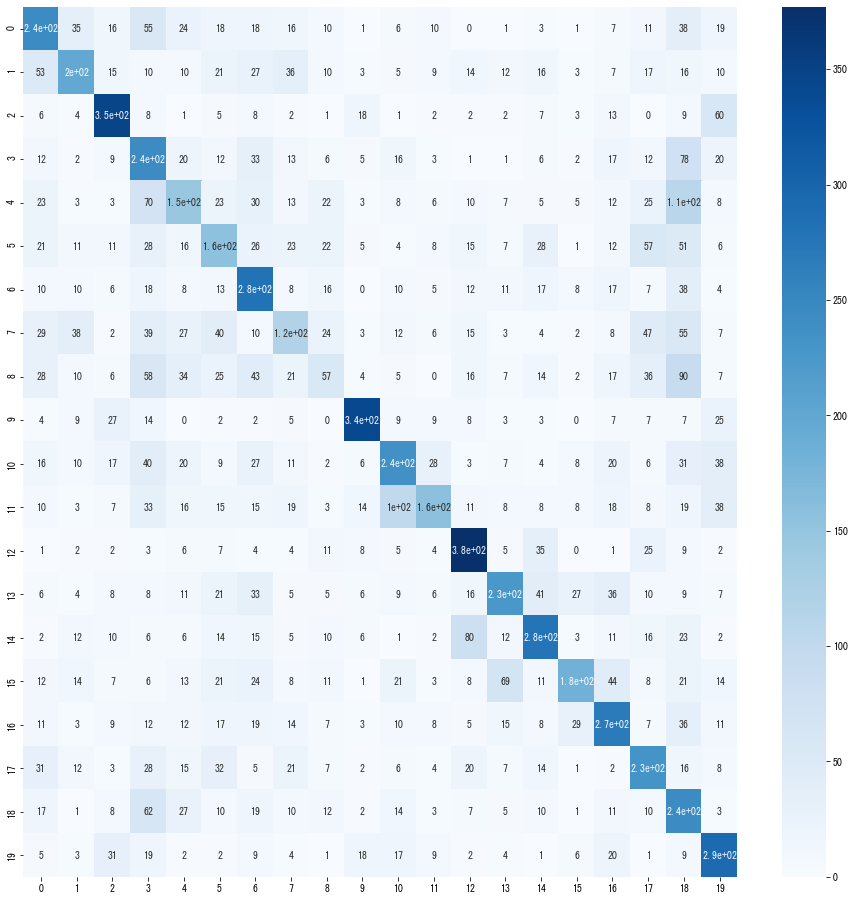

In [104]:
pred_classes = np.argmax(
    model.predict(valid_gen, steps=valid_gen.n // valid_gen.batch_size + 1), 
    axis=1
)
true_classes = valid_gen.classes
classe_labels = list(valid_gen.class_indices.keys())

conf_mat = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(16, 16))
sns.heatmap(conf_mat, cmap='Blues', annot=True, cbar=True)
print(classification_report(true_classes, pred_classes))

## Create submission

In [113]:
pred_test = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size + 1)

In [116]:
pred_test

array([[0.4600691 , 0.04223768, 0.04802381, ..., 0.00613867, 0.04657533,
        0.0616647 ],
       [0.03783769, 0.00763487, 0.01013823, ..., 0.026827  , 0.32071343,
        0.01184437],
       [0.17651734, 0.03721972, 0.01418863, ..., 0.05361307, 0.04905069,
        0.03150021],
       ...,
       [0.04408561, 0.03413277, 0.15916906, ..., 0.12550046, 0.02137093,
        0.01955256],
       [0.07549586, 0.01744032, 0.01650656, ..., 0.02206422, 0.17580004,
        0.03201228],
       [0.02045563, 0.05643488, 0.02055108, ..., 0.02571671, 0.00788911,
        0.00778282]], dtype=float32)

In [133]:
sample_submit = pd.read_csv("../data/input/sample_submit.csv", header=None)
sample_submit.iloc[:, 1:] = pred_test
sample_submit.to_csv('../data/output/submit_' + dt + '.csv', header=None, index=False)